# Automated Face Detection & Morphing

## Setup

In [1]:
import delaunay
import cv2
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from scipy.spatial import Delaunay
import warping
reload(delaunay)

/Users/sonalimerchia/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<module 'delaunay' from '/Users/sonalimerchia/Desktop/CS445/FinalProject/delaunay.py'>

## Face detection in images

In [ ]:
image = cv2.cvtColor(cv2.imread('img_341.jpg'), cv2.COLOR_BGR2GRAY)
faces = delaunay.detect_faces(image)
face_images = delaunay.crop_faces([image], [(0, *face) for face in faces])
keypoints = delaunay.get_face_keypoints(face_images)
plt.figure()
plt.imshow(image, cmap='gray')
for face_image, feature_points in zip(face_images, keypoints):
    if feature_points is None:
        continue
    plt.figure()
    plt.imshow(face_image, cmap='gray')
    for (x, y) in feature_points:
        plt.plot(x, y, 'ro')
plt.show()

### SSD vs. previously tagged faces (TODO)

## Delaunay Algorithm

In [ ]:
triangulations = delaunay.create_triangulations(keypoints)

for face_image, feature_points, triangulation in zip(face_images, keypoints, triangulations):
    if triangulation is None:
        continue
    plt.figure()
    plt.imshow(face_image, cmap='gray')
    plt.triplot(feature_points[:, 0], feature_points[:, 1], triangulation)
plt.show()

## Interpolate the triangulations

In [ ]:
def get_image(file):
    return cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)

def get_face(args):
    i, image = args
    faces = delaunay.detect_faces(image)
    assert len(faces) > 0
    return (i, *faces[0])

num_interpolations = 2
test_case_images = [
    ("case_2_1.png", "case_2_2.jpeg"),
    ("case_3_1.jpeg", "case_1_2.png"),
]

fig, ax = plt.subplots(len(test_case_images) * 2, num_interpolations + 1)
fig.set_figwidth(15)
fig.set_figheight(15)
for test_case_index, files in enumerate(test_case_images):
    images = list(map(get_image, files))
    faces = list(map(get_face, enumerate(images)))
    cropped_faces = delaunay.crop_faces(images, faces)
    keypoints = delaunay.get_face_keypoints(cropped_faces)
    interpolations = delaunay.interpolate_triangulations(*keypoints, num_interpolations=num_interpolations)


    for image_index, (image, interpolation) in enumerate(zip(cropped_faces, interpolations)):
        for time_index, interpolated in enumerate(interpolation):
            relevant_ax = ax[test_case_index * 2 + image_index, time_index]
            relevant_ax.set_title("Step " + str(time_index) + "/" + str(num_interpolations))
            relevant_ax.imshow(image, cmap='gray')
            relevant_ax.triplot(interpolated[0][:, 0], interpolated[0][:, 1], interpolated[1])
            
plt.show()

## Warp both images

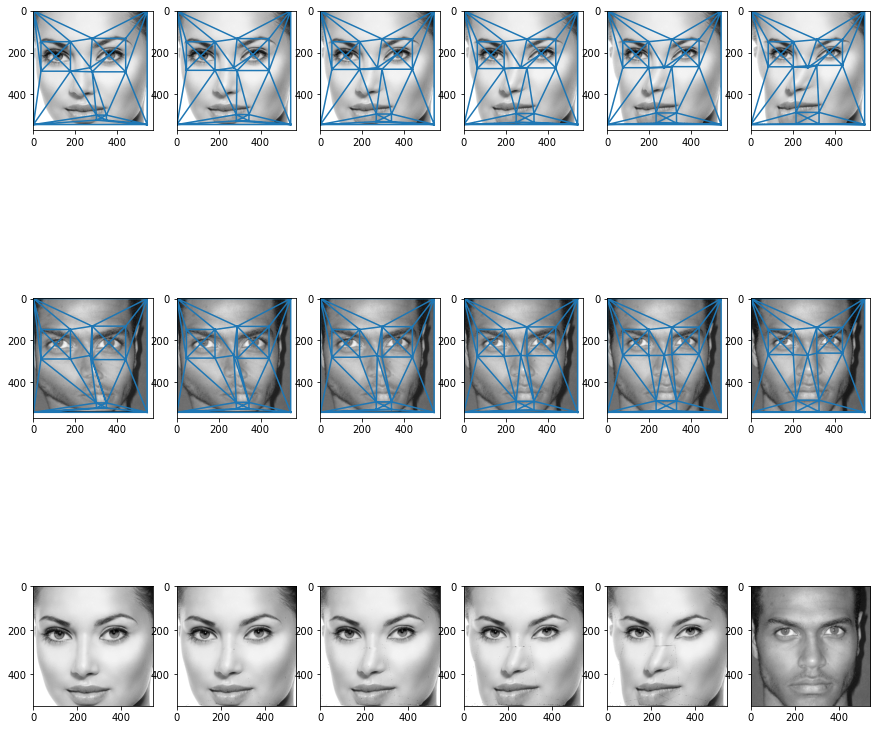

In [18]:
reload(warping)

# Load images
image1 = cv2.cvtColor(cv2.imread("case_2_1.png"), cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(cv2.imread('case_3_1.jpeg'), cv2.COLOR_BGR2GRAY)
num_interpolations = 5

# Detect faces
face1 = delaunay.detect_faces(image1)
face2 = delaunay.detect_faces(image2)

cropped_faces = delaunay.crop_faces([image1, image2], [(0, *face1[0]), (1, *face2[0])])
keypoints = delaunay.get_face_keypoints(cropped_faces)

# Determine point locations at each time step
(im1inters, im2inters) = delaunay.interpolate_triangulations(*keypoints, num_interpolations=num_interpolations)

fig, ax = plt.subplots(3, num_interpolations + 1)
fig.set_figwidth(15)
fig.set_figheight(15)
morphed_images = np.zeros((num_interpolations+1, *cropped_faces[0].shape))

# Plot initial images
ax[0, 0].imshow(cropped_faces[0], cmap='gray')
ax[0, 0].triplot(keypoints[0][:, 0], keypoints[0][:, 1], im1inters[0][1])
ax[1, -1].imshow(cropped_faces[1], cmap='gray')
ax[1, -1].triplot(keypoints[1][:, 0], keypoints[1][:, 1], im2inters[0][1])

morphed_images[0] = cropped_faces[0]
morphed_images[-1] = cropped_faces[1]

simplexes_im1 = im1inters[0][1]
simplexes_im2 = im2inters[0][1]

for time_idx in range(1, num_interpolations+1): 
    final_pts_im1 = im1inters[time_idx][0]
    final_pts_im2 = im2inters[time_idx][0]

    # warp images
    out_img1 = warping.get_morphed_image(keypoints[0], final_pts_im1, simplexes_im1, cropped_faces[0])
    out_img2 = warping.get_morphed_image(keypoints[1], final_pts_im2, simplexes_im2, cropped_faces[1])

    # Plot them with their triangulations
    ax[0, time_idx].imshow(out_img1, cmap='gray')
    ax[0, time_idx].triplot(final_pts_im1[:, 0], final_pts_im1[:, 1], simplexes_im1)
    ax[1, num_interpolations-time_idx].imshow(out_img2, cmap='gray')
    ax[1, num_interpolations-time_idx].triplot(final_pts_im2[:, 0], final_pts_im2[:, 1], simplexes_im2)
    
    # interpolate values for morphed images
    if time_idx < num_interpolations + 1: 
        morphed_images[time_idx] += out_img1 * (1-0.2*time_idx)
#         morphed_images[num_interpolations-time_idx] += out_img2 * (0.2)*(num_interpolations-time_idx)

 
# plot morphing
for time_idx in range(num_interpolations+1): 
    ax[2, time_idx].imshow(morphed_images[time_idx], cmap='gray')

## Cross-dissolve the colors

## Create video